# ITCS 6010/8010 Assignment1
**Due date: 11:59 pm EDT on Sep 20, 2024 (Fri.)**

---
For this course, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your UNC Charlotte (*.uncc.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This codebase provides an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In this assignment you will train a deep convolutional network to recognize scenes. The starter codes gives you methods to load data and display them. Here, we will define a simple network architecture that achieves accuracy less than 50%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features.


This is an approach that represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do).

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [454]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random
import time
import albumentations
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

# Replace '------' with the path such that "ITCS_6010_8010_assignment1" is your working directory
%cd '/content/gdrive/My Drive/Assignment2'

## Loading and Preprocessing data
---
In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing.

In [455]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
   torch.manual_seed(seed)
   torch.cuda.manual_seed_all(seed)
   np.random.seed(seed)
   random.seed(seed)
   torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
       augment=False, is_color=False, zero_centered=False, mirror=False, rotate=False, together=False):
  set_random_seed(0)
  data = []
  labels = []
  channel_num = 3 if is_color else 1

  # read images and resizing
  for id, class_name in class_names.items():
    print("Loading images from class: %s" % id)
    img_path_class = glob.glob(path + class_name + '/*.jpg')
    if num_per_class > 0:
      img_path_class = img_path_class[:num_per_class]
    labels.extend([id]*len(img_path_class))
    for filename in img_path_class:
      if is_color:
        img = cv2.imread(filename)
      else:
        img = cv2.imread(filename, 0)

      # resize the image
      img = cv2.resize(img, img_size, cv2.INTER_LINEAR)

      if is_color:
        img = np.transpose(img, [2, 0, 1])

      # norm pixel values to [-1, 1]
      data.append(img.astype(np.float16)/255*2-1)

  # Data Augmentation

  if augment:
    aug_mirror = albumentations.Compose(
      [
        albumentations.HorizontalFlip(p=1),
      ],
    )

    aug_rotate = albumentations.Compose(
      [
        albumentations.Rotate(p=1, border_mode=0, limit=30),
      ],
    )


    dataset_length = len(data)

    if mirror and not rotate:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if rotate and not mirror:
      for i in range(dataset_length):

        img_temp = aug_rotate(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if  mirror and rotate:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])

      for i in range(dataset_length):

        img_temp = aug_rotate(image=data[i])['image']

        data.append(img_temp)
        labels.append(labels[i])


    if together:
      for i in range(dataset_length):

        img_temp = aug_mirror(image=data[i])['image']
        img_temp = aug_rotate(image=img_temp)['image']

        data.append(img_temp)
        labels.append(labels[i])


  # Data Normalization
  if zero_centered:
    if is_color:
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])
    else:
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5), (0.5))
      ])

    # Apply the normalization
    for i in range(len(data)):
      data[i] = transform(data[i])
    # pass


  # randomly permute (this step is important for training)
  if shuffle:
    bundle = list(zip(data, labels))
    random.shuffle(bundle)
    data, labels = zip(*bundle)

  # divide data into minibatches of TorchTensors
  if batch_size > 1:
    batch_data = []
    batch_labels = []

    for i in range(int(len(data) / batch_size)):
      minibatch_d = data[i*batch_size: (i+1)*batch_size]
      minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
      batch_data.append(torch.from_numpy(minibatch_d))

      minibatch_l = labels[i*batch_size: (i+1)*batch_size]
      batch_labels.append(torch.LongTensor(minibatch_l))
    data, labels = batch_data, batch_labels

  return zip(batch_data, batch_labels)

class_names: {0: 'Bedroom', 1: 'Coast', 2: 'Flower', 3: 'Forest', 4: 'Highway', 5: 'Industrial', 6: 'InsideCity', 7: 'Kitchen', 8: 'LivingRoom', 9: 'Mountain', 10: 'Office', 11: 'OpenCountry', 12: 'Store', 13: 'Street', 14: 'Suburb', 15: 'TallBuilding'} 


In [482]:
# load data into size (64, 64)
img_size = (128, 128)
batch_size = 32 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size,zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=32) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from cla

TallBuilding


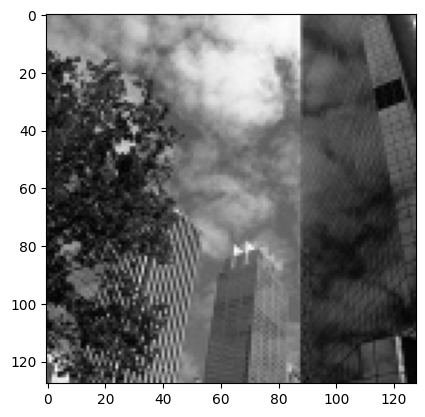

In [483]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Training a Network From Scratch
Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a simpe network architecture.

In [494]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self, num_classes=16):
        super(TNet, self).__init__()

        self.features = torch.nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.SiLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=2, padding=1),
            nn.BatchNorm2d(128),
            nn.SiLU(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(128, 256, kernel_size=2, padding=1),
            nn.BatchNorm2d(256),
            nn.SiLU(),
            nn.MaxPool2d(2, stride=2),
        )


        self.avgpool = nn.AdaptiveAvgPool2d((6,6))

        # Fully connected layer
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6* 6, 512),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Then, let's define model training and evaluation functions.

In [495]:
def trainModel(net, trainloader, train_option, testloader=None):
    loss_func = nn.CrossEntropyLoss()
    lr = train_option['lr']
    epoch = train_option['epoch']
    device = train_option.get('device', 'cpu')
    log_iter = train_option.get('log_iter', 20)
    eval_epoch = 1

    # Create optimizer
    optimizer = train_option.get('optimizer', torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-4))

    # Move model to device
    if device == 'gpu':
        net = net.cuda()

    # Initialize variables to track best accuracy
    best_accuracy = 0.0
    best_model_path = "best_model.pth"  # Change the path as needed
    start_time = time.time()

    for ep in range(epoch):
        net.train()
        running_loss = 0.0
        iters = 0

        for iter, (x, y) in enumerate(trainloader):
            iters += 1
            batch_x = Variable(x).float()
            batch_y = Variable(y).long()
            if device == 'gpu':
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()

            outputs = net(batch_x)
            loss = loss_func(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))

            if iter % log_iter == 0:
                print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f}'.format(
                    ep + 1, iter, time_lapse, loss.item(), running_loss / iters))

        # Evaluate model and save if it improves accuracy
        if testloader is not None and ep % eval_epoch == 0:
            accuracy = evalModel(net, testloader)  # This will now return accuracy

            # Check if the current accuracy is the best
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(net.state_dict(), best_model_path)  # Save the model
                print(f'Saved best model with accuracy: {best_accuracy:.4f} at epoch {ep + 1}')

    print('Training complete. Best accuracy: {:.4f}'.format(best_accuracy))

In [496]:
def evalModel(net, testloader):
    acc = 0.0
    count = 0
    start_time = time.time()
    device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
    net.eval()

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for iter, (x, y) in enumerate(testloader):
            count += x.shape[0]
            batch_x = Variable(x).float()
            batch_y = Variable(y).long()
            if device == 'gpu':
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()

            outputs = net(batch_x)
            acc += torch.sum(outputs.max(1)[1] == batch_y).item()  # Use .item() to convert to Python number

    time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
    accuracy = acc / count  # Calculate accuracy
    print('Accuracy: {:.5f} | Time: {}'.format(accuracy, time_lapse))
    return accuracy  # Return accuracy for use in trainModel

Finally, let's start training and evaluation.

In [498]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet()
train_option = {}
train_option['lr'] = 1e-4
train_option['epoch'] = 150
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7053 | Average Loss: 2.7053
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.1028 | Average Loss: 2.6369
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.2773 | Average Loss: 2.5136
Epoch: 1 | Iter:   60 | Time: 00:00:01 | Train Loss: 2.2181 | Average Loss: 2.4003
Accuracy: 0.42969 | Time: 00:00:00
Saved best model with accuracy: 0.4297 at epoch 1
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 1.7014 | Average Loss: 1.7014
Epoch: 2 | Iter:   20 | Time: 00:00:02 | Train Loss: 1.5329 | Average Loss: 1.7216
Epoch: 2 | Iter:   40 | Time: 00:00:02 | Train Loss: 1.3816 | Average Loss: 1.7347
Epoch: 2 | Iter:   60 | Time: 00:00:03 | Train Loss: 1.4885 | Average Loss: 1.6709
Accuracy: 0.51042 | Time: 00:00:00
Saved best model with accuracy: 0.5104 at epoch 2
Epoch: 3 | Iter:    0 | Time: 00:00:03 | Train Loss: 1.4221 | Average Loss: 1.4221
Epoch: 3 | Iter:   20 | Time: 00:00:04 | Train Loss: 1.1150 | Average Loss: 1.3304


Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

## Submission guidelines
---
Please submit a pdf file that includes a ***gitlab link*** of your codes. This pdf file should be named as **Surname_Givenname_UNCCID_assignment1.pdf** (example: Jordan_Michael_800134567_assignment1.pdf for this assignment). This pdf will be used for a similarity checking of your codes.


You are encouraged to post and answer questions on Canvas. Please ask questions on Canvas and send emails to the instructor only for personal issues.


Be aware that your report will undergo plagiarism check both vertically and horizontally. Please do not duplicate your reports from your classmates.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have THREE days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.